In [4]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
from transformers import TFDistilBertForSequenceClassification, Trainer, TFTrainingArguments
from transformers import TextClassificationPipeline

import pandas as pd
import json
import gc

from sklearn.model_selection import train_test_split

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopw = set(stopwords.words('french'))

import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot

from tqdm import tqdm



[nltk_data] Downloading package stopwords to
[nltk_data]     /home/utilisateur/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
df = pd.read_csv('../dataset.csv')
df.head()

,Unnamed: 0,url,title,description,cat1,cat2,cat3
0,0,https://www.tourisme-cambresis.fr/1-les-templi...,"Aventure-jeu : ""Les Templiers du coffre d'or""",Le jeu aventure « Les templiers du coffre d’or...,Jeu,Famille,Détente
1,1,https://www.tourisme-cambresis.fr/exposition-t...,"Exposition ""le tank dans tous ses états""","L'apparition des tanks, arme de guerre incarna...",Exposition,Culture,NaN
2,1,https://www.tourisme-cambresis.fr/femme-premie...,"Exposition ""La femme au premier millénaire""",L’exposition vous invite à une plongée au cœur...,Exposition,Culture,NaN
3,3,https://www.tourisme-cambresis.fr/exposition-a...,"Exposition ""L'archéologie à Vaucelles, une his...","L’abbaye de Vaucelles, monument culturel du Dé...",Exposition,Culture,Histoire
4,2,https://www.tourisme-cambresis.fr/exposition-e...,"Exposition ""Les chasseurs cyclistes au combat ...","Exposition ""Les chasseurs cyclistes au combat ...",Exposition,Histoire,Culture


In [6]:
#garder colonne description, cat1

df = df[['description', 'cat1']]

#supprimer le manquant dans la colonne description

df = df.dropna(subset=['description'])

#supprimer les retours à la ligne dans la colonne description

df['description'] = df['description'].str.replace('\n', ' ')

df.head()

,description,cat1
0,Le jeu aventure « Les templiers du coffre d’or...,Jeu
1,"L'apparition des tanks, arme de guerre incarna...",Exposition
2,L’exposition vous invite à une plongée au cœur...,Exposition
3,"L’abbaye de Vaucelles, monument culturel du Dé...",Exposition
4,"Exposition ""Les chasseurs cyclistes au combat ...",Exposition


In [ ]:
df.shape

(390, 2)

<Figure size 800x800 with 0 Axes>

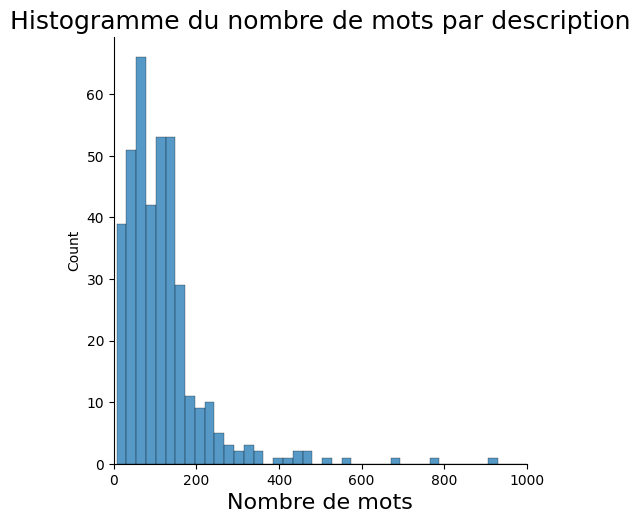

In [ ]:
# histogramme nombre de mots ds description

df['count'] = df['description'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 8))

sns.displot(df['count'])

plt.xlim(0, 1000)
plt.xlabel('Nombre de mots', fontsize=16)
plt.title('Histogramme du nombre de mots par description', fontsize=18)
plt.show()



In [ ]:
# bar plot pour chaque catégorie

categories_count = df['cat1'].value_counts()

categories = categories_count.index

categories


Index(['Visite', 'Concert', 'Exposition', 'Spectacle', 'Balade', 'Sport',
       'Atelier', 'Brocante', 'Théatre', 'Fête', 'Détente', 'Marché',
       'Conférence', 'Danse', 'Culture', 'Jeu', 'Festival', 'Famille',
       'Environnement', 'Action'],
      dtype='object', name='cat1')

/tmp/ipykernel_321848/2677129453.py:8: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



Text(0, 0.5, 'Catégorie')

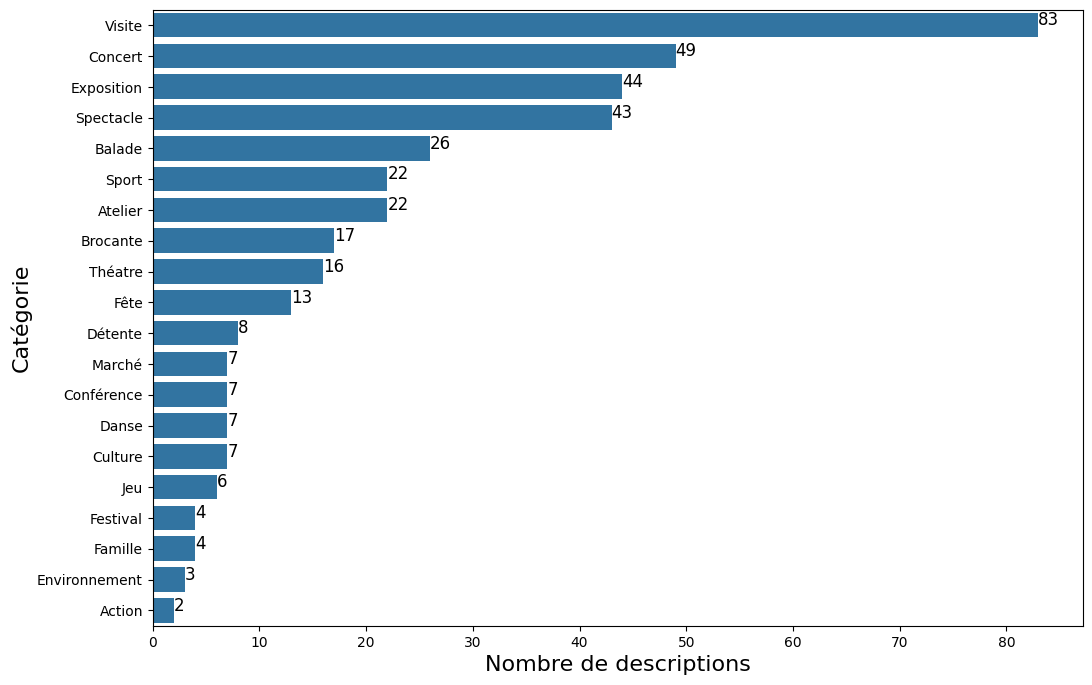

In [ ]:
fig = plt.figure(figsize=(12, 8))

ax = fig.add_subplot(111)

sns.barplot(x=categories_count, y=categories, ax=ax)

for a,p in enumerate(ax.patches):
    ax.annotate(f'{categories_count[a]}', (p.get_width(), a), fontsize=12)
    
plt.xlabel('Nombre de descriptions', fontsize=16)
plt.ylabel('Catégorie', fontsize=16)
                                    

In [10]:
#balacing classes

from imblearn.over_sampling import RandomOverSampler

oversampler = RandomOverSampler(random_state=0)

#fit random oversampler to data
X = df['description'].apply(lambda x: len(x.split())).values.reshape(-1, 1)
y = df['cat1']

X_resampled, y_resampled = oversampler.fit_resample(X, y)

#resampled data
df = pd.DataFrame({'description': X_resampled.flatten(), 'cat1': y_resampled})

/tmp/ipykernel_349749/2186478547.py:12: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



Text(0, 0.5, 'Catégorie')

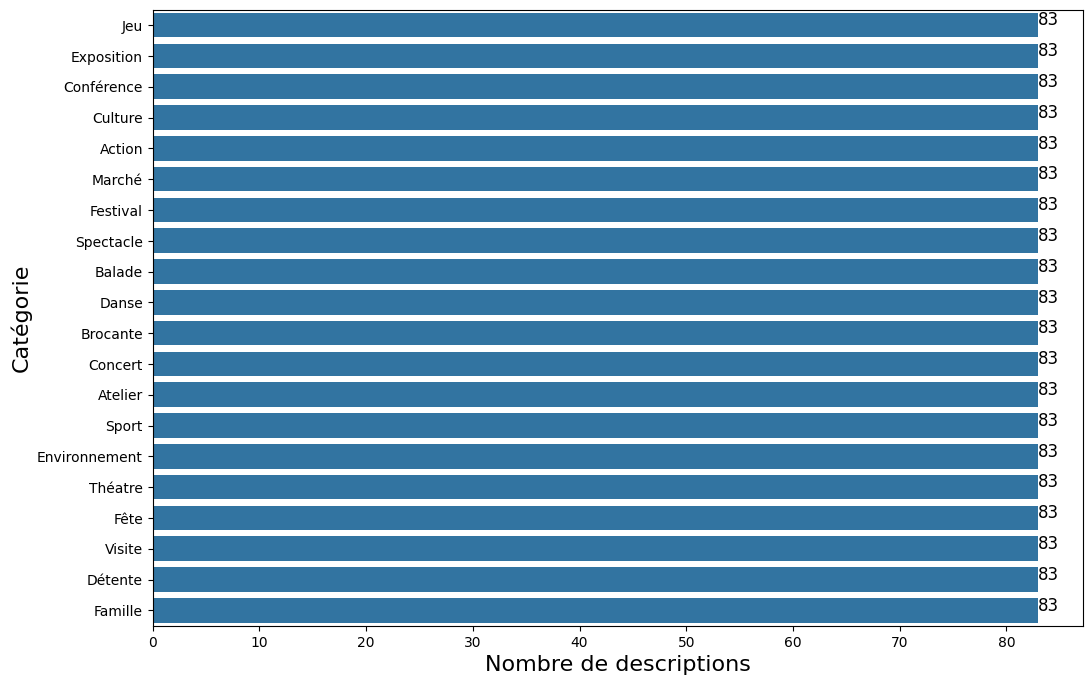

In [13]:
categories_count = df['cat1'].value_counts()

categories = categories_count.index

fig = plt.figure(figsize=(12, 8))

ax = fig.add_subplot(111)

sns.barplot(x=categories_count, y=categories, ax=ax)

for a,p in enumerate(ax.patches):
    ax.annotate(f'{categories_count[a]}', (p.get_width(), a), fontsize=12)
    
plt.xlabel('Nombre de descriptions', fontsize=16)
plt.ylabel('Catégorie', fontsize=16)

In [ ]:
#encoder les catégories


df['encoded_text'] = df['cat1'].astype('category').cat.codes

df.head()

df['encoded_text'].unique()


array([14, 10,  8, 19, 13, 18,  9, 17,  1,  4,  3,  7,  2, 16, 12, 15,  0,
        6,  5, 11], dtype=int8)

In [ ]:
data_texts = df['description'].to_list()

data_labels = df['encoded_text'].to_list()



In [ ]:
#Train test split

train_texts, test_texts, train_labels, test_labels = train_test_split(data_texts, data_labels, test_size=0.2, random_state=0)

train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.01, random_state=0)


In [ ]:
# model definition

tokenizer = AutoTokenizer.from_pretrained('distilbert/distilbert-base-multilingual-cased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True)

val_encodings = tokenizer(val_texts, truncation=True, padding=True)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

In [ ]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

# Specify the training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

# Load the model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-multilingual-cased', num_labels=20)

# Initialize the Trainer
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

# Train the model
trainer.train()

# import torch
# from torch.utils.data import DataLoader
# from transformers import DistilBertForSequenceClassification, AdamW

# # Load model
# model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-multilingual-cased', num_labels=20)

# # Specify GPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

# # Create the DataLoaders for our training and validation datasets.
# train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=16)
# validation_dataloader = DataLoader(val_dataset, batch_size=64)

# # Optimizer
# optimizer = AdamW(model.parameters(), lr=1e-5)

# # Training loop
# for epoch in range(3):
#     total_train_loss = 0
#     model.train()
#     for step, batch in enumerate(train_dataloader):
#         b_input_ids = batch['input_ids'].to(device)
#         b_labels = batch['labels'].to(device)

#         model.zero_grad()        
#         outputs = model(b_input_ids, labels=b_labels)
#         loss = outputs.loss
#         total_train_loss += loss.item()
#         loss.backward()
#         optimizer.step()

#     # Validation
#     model.eval()
#     total_eval_accuracy = 0
#     total_eval_loss = 0
#     for batch in validation_dataloader:
#         b_input_ids = batch['input_ids'].to(device)
#         b_labels = batch['labels'].to(device)
        
#         with torch.no_grad():        
#             outputs = model(b_input_ids, labels=b_labels)

#         loss = outputs.loss
#         total_eval_loss += loss.item()

#     print(f"Training Loss: {total_train_loss / len(train_dataloader)}")
#     print(f"Validation Loss: {total_eval_loss / len(validation_dataloader)}")

ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.21.0`: Please run `pip install transformers[torch]` or `pip install accelerate -U`

In [ ]:
trainer.train()

In [ ]:
trainer.evaluate()

In [ ]:
#saving et loading du model

save_directory = './saved_models'

model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)






In [ ]:
#loading pretrained model

tokenizer_fine_tuned = AutoTokenizer.from_pretrained(save_directory)

model_fine_tuned = TFDistilBertForSequenceClassification.from_pretrained(save_directory)


"Le sanctuaire de Schoenstatt vous ouvre ses portes à l'occasion des Journées Européennes du Patrimoine, le samedi 16 septembre de 10h à 18h."

In [ ]:
test_text = test_texts[0]

test_text



"Le sanctuaire de Schoenstatt vous ouvre ses portes à l'occasion des Journées Européennes du Patrimoine, le samedi 16 septembre de 10h à 18h."

In [ ]:
predic_input = tokenizer_fine_tuned.code(
    test_text,
    truncation=True,
    padding=True,
    return_tensors='tf'
)

output = model_fine_tuned.predict(predic_input)[0]

prediction_value = tf.argmax(output, axis=1).numpy()[0]

prediction_value



NameError: name 'tokenizer_fine_tuned' is not defined